## Travail Personnel 2 : " Traffic flow ".

---


L'objectif de ce nouveau travail personnel est de réussir à modéliser et à décrire le système qu'est le flux de la circulation sur une route à une seule voie.

Pour se faire, nous nous plaçerons ici dans le cas d'un trafic instable pour lequel nous pouvons utiliser l'équation de convection non-linéaire de la densité de voiture. En outre, nous procèderons à 2 simulations distingues afin de mieux comprendre l'évolution de notre système sous différente conditions initiales (CI) et aux bords/limites (CL) pour la densité de trafic. Nous aurons ainsi les 2 ensemble de conditions suivant :

Première simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).10\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 10
    \end{array}
\right \} \text{  (CL)}
$$

Seconde simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).20\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 20
    \end{array}
\right \} \text{  (CL)}
$$

Commençons sans plus tarder par le traitement de nos équations.

##### 1. Réécriture de l'équation de convection non-linéaire de la densité de voiture & discrétisation. 
---

**1.1 Un bref rappel théorique.**

---

Dans la partie théorique de l'énoncé de ce travail, nous avons vu que le flux, instable, de trafic peut-être modélisé comme la convection non-linéaire de la densité de voiture. Il en découllait donc pour notre problème:

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0\\
\end{align}


où

\begin{align}
F = V(\rho) \rho = V_{max} \rho \left( 1- \frac{\rho}{\rho_{max}} \right)
\end{align}

Avec,

$$
\left\{
    \begin{array}{ll}
        &.V  \text{, la vitesse de circulation (en km/h)} \\
        &.V_{max}  \text{, vitesse maximale que peuvent atteindre les}\\
        &\hspace{0.9cm}  \text{voiture lorsque $\rho→0$}\\
        &.\rho \text{, la densité de trafic, c'est à dire le nombre de voiture}\\
        &\hspace{0.9cm}  \text{par unité de longueur de la route (en voiture/km)}\\
        &. \rho_{max},  \text{la densité maximale atteinte lorsque les voiture}\\
        &\hspace{0.9cm}  \text{sont "pare-chocs contre pare-chocs", et à laquelle}\\
        &\hspace{0.9cm}  \text{correspond une vitesse nulle}
    \end{array}
\right.
$$

En appliquant la $règle\ de\ la\ chaîne^{1}$ sur l'équation (1), nous obtenons alors: 

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0\\
\end{align}


Nous allons maintenant passé à la discrétisation (afin de pouvoir résoudre numériquement notre problème) de nos équations. En effet, nous n'allons pas uniquement discrétisé l'équation (3) mais nous allons également discrétisé l'équation (1) et ce dans le but de comparé les résultats obtenu par ces deux discrétisations différentes et d'en tirer d'éventuelles conclusions.

---
###### [1]. La règle de dérivation des fonctions composées ou "règle de la chaîne" s'énonce comme suit : Soit f une fonction dérivable en a et g dérivable en f(a). Alors la composition g o f est dérivable en a et on a : $(g◦f)'(a) = g'(f(a)) f'(a)$ ou dans la notation de Leibniz si $y=f(x)$ et $u=g(y)$ alors : $\frac{du}{dx}=\frac{du}{dy} \frac{dy}{dx}$


** 1.2 Discrétisations. **

---

Passons à présent à la discrétisation de nos équation et commençons par l'équation (1). 

Pour se faire, nous calculons tout d'abord la dérivée $\frac{\partial F}{\partial \rho}$. Nous pourrions calculer cette dérivée à la main mais nous nous proposons d'utiliser ce que nous avons appris au cours du dernier notebook de la série *Space and Time — Introduction to Finite-difference solutions of PDEs*, e.g. l'emplois de l'une des fonctionnalités proposées par $sympy^{2}$ : le calcul d'une dérivée partielle. 

---
###### [2] . Sympy est une librairie pour python qui propose de nombreuse fonctionnalités similaires à celle proposée par Mathematica tel que le calcul de dérivée, d'integrale, etc.

Commençons donc par importer la librairie sympy.

In [1]:
# Import de la libraire.
import sympy

# Permet le renvois des résultats dans le style "LaTeX".
from sympy import init_printing
init_printing()

Définissons à présent nos variables, l'expression de F (donnée par l'équation (2) ) et calculons enfin sa dérivée par rapport à $\rho$.

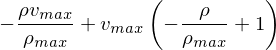

In [2]:
# On définit nos variables.
v_max, rho, rho_max = sympy.symbols('v_max, rho, rho_max')

# Expression de F.
F = v_max*rho*(-(rho/rho_max)+1)

# Calcul de la dérivée.
Fprime = F.diff(rho)

# Affichage du résultat.
Fprime

Ce qui est le même résultat que celui obtenu à la main si nous réexprimons ceci en mettant $v_{max}$ en évidence et en simplifiant quelque peu l'expression:


$\hspace{2.5cm}\frac{- \rho v_{max}}{\rho_{max}}+ v_{max} \left( - \frac{\rho}{\rho_{max}}+1 \right)$ → $v_{max} \left( 1- \frac{2 \rho}{\rho_{max}} \right)$

Ainsi, nous avons obtenu grâce à sympy :

\begin{equation}
\frac{\partial F}{\partial \rho} = v_{max} \left( 1- \frac{2 \rho}{\rho_{max}} \right) 
\end{equation}

Et l'équation (1) devient alors :

\begin{equation}
\frac{\partial \rho}{\partial t} + v_{max} \left( 1- \frac{2 \rho}{\rho_{max}} \right)  \frac{\partial \rho}{\partial x} = 0\\
\end{equation}

Nous pouvons à présent passer à la discrétisation de notre equation de convection. Pour se faire, nous utilisons comme demandé dans l'énoncé de ce travail personnel, la *forward-difference* pour la dérivée par rapport au temps et la *backward-difference* pour la dérivée par rapport à l'espace (ici, par rapport à x comme nous travaillons avec une équation à 1 dimension).

Pour rappel, les discrétisations *forward-difference* et *backward-difference* de la dérivée partielle $\frac{\partial u}{\partial x}$ (par exemple) sont données par :

* Forward-difference: si on utilise les points $x_i$ et $x_i + \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_{i+1})-u(x_i)}{\Delta x}$.
* Backward-difference: si on utilise les points $x_i$ et $x_i- \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_i)-u(x_{i-1})}{\Delta x}$.

Donc en appliquant ces deux discrétisations à l'équation (5) il en découle l'équation suivante:

\begin{equation}\frac{\rho_i^{n+1}-\rho_i^n}{\Delta t} + v_{max} \left( 1- \frac{2 \rho_i^{n}}{\rho_{max}} \right) \frac{\rho_i^n - \rho_{i-1}^n}{\Delta x} = 0, \end{equation}

Où la seule inconnue est $\rho_i^{n+1}$ étant donné nos conditions initiales. En isolant cette inconnue nous obtenons :

\begin{equation}
\rho_{i}^{n+1}= \rho_{i}^{n} - v_{max} \frac{\Delta t}{\Delta x} \left( 1- \frac{2 \rho_{i}^{n}}{\rho_{max}} \right) \left( \rho_{i}^n - \rho_{i-1}^n \right)
\end{equation}

Que nous pouvons maintenant traiter numériquement.


Procédons maintenant à la discrétisation de notre seconde équation, l'équation (3). À nouveau, nous utilisons les deux discrétisation demandées. Nous obtenons ainsi :

$$
\left\{
    \begin{array}{}
        \frac{\partial F}{\partial x}  \approx \frac{F_{i}^{n}-F_{i-1}^{n}}{\Delta x}\\
        \frac{\partial \rho}{\partial t}  \approx \frac{\rho_{i}^{n+1}-\rho_{i}^{n}}{\Delta x}
    \end{array}{}
\right.
$$

où
$$
\left\{
    \begin{array}{}
        F_{i}^{n} & = v_{max} \rho_{i}^{n} \left( 1- \frac{\rho_{i}^{n}}{\rho_{max}} \right)\\
        F_{i-1}^{n} & = v_{max} \rho_{i-1}^{n} \left( 1- \frac{\rho_{i-1}^{n}}{\rho_{max}} \right)
    \end{array}{}
\right.
$$

Ainsi si on réintroduit ceci dans l'équation (3) et qu'on isole la seule inconnue $\rho_i^{n+1}$, nous obtenons alors l'équation discrétisée :

\begin{equation}
\rho_{i}^{n+1}= \rho_{i}^{n} - v_{max} \frac{\Delta t}{\Delta x} \left[\rho_{i}^{n} \left( 1- \frac{ \rho_{i}^{n}}{\rho_{max}} \right) - \rho_{i-1}^n\left( 1 - \frac{ \rho_{i-1}^{n}}{\rho_{max}} \right) \right]
\end{equation}

---
##### 2. Résolution du problème suivant la discrétisation de l'équation (1).

---

#### PARTIE A .
---

Comme à notre habitude, nous commençons par importer les librairies "numpy", matplotlib et JSAnimation. Ce dernier sera utile pour animer nos graphes.

In [64]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Nous déclarons ensuite nos données pour cette première partie à savoir la vitesse maximale du trafic,la longueur de la route,...

In [65]:
# Déclaration des variables
v_max = 80  # en km/h
L     = 11       # en km
rho_max = 250  # en voitures/km
nx    = 51
dx    = L/(nx-1)
dt    = 0.001     # h

Et nos conditions initiales, e.g. une densité de voiture décrite de la manière suivante:

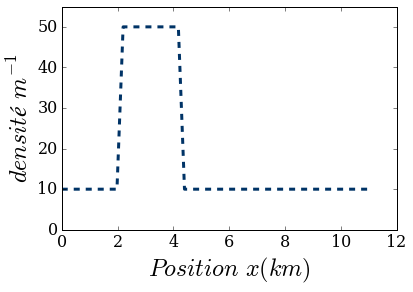

In [66]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50
pyplot.ylabel('$densité$'' ''$m^{-1}$', fontsize=24) # nom de l'axe x & taille de la police
pyplot.xlabel('$Position$'' ''$x(km)$', fontsize=24) # nom de l'axe y & taille de la police
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,55);

** Question 1:**

Afin de répondre aux questions du problème, nous commençons par définir une fonction pour la vitesse du trafic qui reprend simplement l'expression de l'équation (2) (que l'on a divisé par $\rho$ pour n'obtenir que l'expression recherchée de la vitesse). Cette fonction nous permettra de ressortir la vitesse du trafic pour un temps donné compte tenu de la densité à ce même moment.

In [67]:
def v(rho):

    return v_max*(1-(rho/rho_max))

Dès lors, nous pouvons utiliser cette fonction ainsi que l'une des fonction de numpy, la fonction min(), pour calculer la vitesse minimal à l'instant inital t = 0 s. 

In [74]:
v_min= min(v(rho0))*10/36   # Où le facteur "10/36" est un facteur de convertion des unités
print("→ Vitesse minimale du trafic à l'instant t = 0s : v =",round(v_min,2),"m/s")

→ Vitesse minimale du trafic à l'instant t = 0s : v = 17.78 m/s


---
**Question2: A t=3min**

---

Pour répondre à cette 2e question, il nous faut spécifier un temps de simulation (de 3 min pour cette première partie). De là, nous pourrons calculer le nt (le nombre de point de notre "grille temporelle") nécessaire à la détermination de la densité au temps associé. Nous avons donc le code suivant:

In [ ]:
# Déclaration des variables
t_sim = 3   #min
nt    = int(t_sim/(dt*60))+1

In [ ]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

In [ ]:
#rhon = rho0.copy() 
#rho[1:] = rhon[1:]- dt/dx* v_max *(1-2*rhon[1:]/rho_max)*(rhon[1:]-rhon[0:-1])
# Boucle temporelle
for n in range(1, nt-1):
    rhon = rho0.copy() 
    rho0[1:] = rhon[1:]- dt/dx* v_max *(1-2*rhon[1:]/rho_max)*(rhon[1:]-rhon[0:-1])
    rho0[0]=10    # Notre condition au bord

In [ ]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,60);
pyplot.xlim(0,20);

In [ ]:
En esquissant le graphe de la densité en fonction de la distance, nous observons que le signal carré de départ est devenu un signal plus courbé (comme vu dans les leçons) #discussion à suivre

Pour bien visualiser la solution, nous pouvons annimer le graphe afin de voir que la densité varie au cours du temps.

fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,20), ylim=(0,60))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]

def trafic(i):
    line.set_data(x,rho0)
    
    rhon = rho0.copy() 
    rho0[1:] = rhon[1:]-((dt/dx) * v_max*(1-((2/rho_max)*rhon[1:]))*(rhon[1:]-rhon[0:-1]))
    rho0[0]=10

animation.FuncAnimation(fig, trafic,
                        frames=nt, interval=10)

A présent, nous pouvons calculer la vitesse moyenne à t=3min à l'aide de "numpy.mean()" appliqué à la fonction qui représente la vitesse du trafic que nous avons définit plus haut.

In [ ]:
v_moy= numpy.mean(v(rho0))*10/36
print("La vitesse moyenne à t=3min","v_moy(t3)=",round(v_moy,2) ,"m/s")

** Question 3 : à t = 6 min

In [75]:
# Déclaration des variables
t_sim = 6   #min
nt    =int(t_sim/(dt*60))+1

In [ ]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho = numpy.ones(nx)*10
rho[10:20] = 50

# Boucle temporelle
for n in range(1, nt):  
    rhon = rho.copy() 
    rho[1:] = rhon[1:]- dt/dx* v_max *(1-2*rhon[1:]/rho_max)*(rhon[1:]-rhon[0:-1])
    rho[0]=10    # Notre condition au bord

In [ ]:
pyplot.plot(x, rho, color='#003366', ls='--', lw=3)
pyplot.ylim(0,60);

In [ ]:
w_min= min(v(rho))*10/36
print("w_min(t6)=",round(w_min,2),"m/s")

---

#### PARTIE B.
---

In [ ]:
v_max = 136  # en km/h
L     = 11       # en km
rho_max = 250     # en voitures/km
nx    = 51
dt    = 0.001     # h
dx    = L/(nx-1)

In [ ]:
x = numpy.linspace(0,L,nx)
rho02 = numpy.ones(nx)*20 
rho02[10:20] = 50

In [ ]:
pyplot.plot(x, rho02, color='#003366', ls='--', lw=3)
pyplot.ylim(0,60);

In [ ]:
v_min2=min(v(rho02))*10/36
print("v_min2=",round(v_min2,2),"m/s")

** Question 2:

In [ ]:
t_sim = 3   #min
nt    =int(t_sim/(dt*60))+1

In [ ]:
x = numpy.linspace(0,L,nx)
rho02 = numpy.ones(nx)*20 
rho02[10:20] = 50


for n in range(1, nt):  
    rho_n = rho02.copy() 
    rho02[1:] = rho_n[1:]- dt/dx* v_max *(1-2*rho_n[1:]/rho_max)*(rho_n[1:]-rho_n[0:-1])
    rho02[0]=20    # Notre condition au bord

In [ ]:
pyplot.plot(x, rho02, color='#003366', ls='--', lw=3)
pyplot.ylim(0,60);

In [ ]:
v_moy2= numpy.mean(v(rho02))*10/36
print("v_moy2(t3)=",round(v_moy2,2),"m/s")

---
##### 3. Résolution du problème suivant la discrétisation de l'équation (3).

---

#### PARTIE A .
---

In [45]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

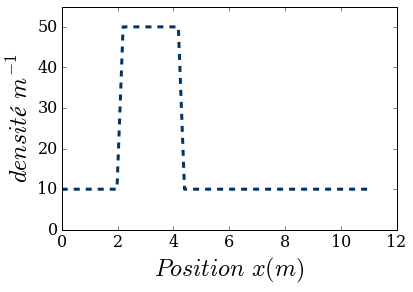

In [46]:
pyplot.ylabel('$densité$'' ''$m^{-1}$', fontsize=24) # nom de l'axe x & taille de la police
pyplot.xlabel('$Position$'' ''$x(m)$', fontsize=24) # nom de l'axe y & taille de la police
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,55);

Quest 1

In [47]:
# Déclaration des variables

v_max = 80       # en km/h
L     = 11       # en km
rho_max = 250    # en voitures/m
nx    = 51      # Nombre de point de la grille d'espace
dt    = .001

In [48]:
def v(rho0):

    return v_max*(1-(rho0/rho_max))

In [49]:
c = min(v(rho0))
print(round(c*10/36,2))

17.78


Introduction des quest 2-3

In [50]:
def v(rho0):

    return v_max*(1-(rho0/rho_max))

In [51]:
def convection1(CL, t_simu, v_max):
    
    """
    
    
    """
    
    # On pose nos paramètres
    L     = 11      # en km
    rho_max = 250   # en voitures/m
    nx    = 51      # Nombre de point de la grille d'espace
    dt    = .001    
    nt = int((t_simu/(dt*60))+1)      # Nombre de point requis dans la grille pour la simulation
    
    #On pose nos conditions intiales 
    x = numpy.linspace(0,L,nx)
    rho0 = numpy.ones(nx)*CL
    rho0[10:20] = 50
    
    
    #On calcul notre inconnue pour tout temps
    for n in range(1, nt):
        rhon = rho0.copy() 
        rho0[1:] = rhon[1:]-((dt/dx)*v_max*((rhon[1:]*(1-(rhon[1:]/rho_max)))-(rhon[0:-1]*(1 - (rhon[0:-1]/rho_max)))))
        rho0[0]=CL    # Notre condition au bord
    
    pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
    pyplot.ylim(0,55);
    pyplot.xlim(0,15);
    
    rho_moy = numpy.mean(rho0)
    v_moy=v_max*(1-(rho_moy/rho_max))
    
    v_min = min(v(rho0))
    
    vit[0] = v_moy
    vit[1] = v_min

Q2( avec réécriture des codes)

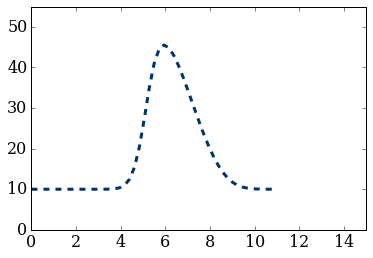

In [52]:
CL     = 10
t_simu = 3
v_max  = 80

vit = numpy.empty(2)
convection1(CL, t_simu, v_max)

In [53]:
print(round(vit[0]*10/36,2))

20.64


Q3( avec réécriture des codes)

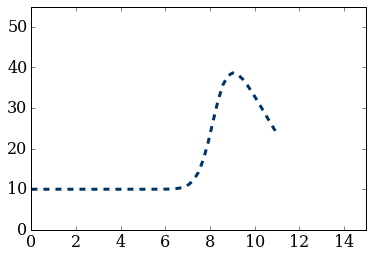

In [54]:
CL     = 10
t_simu = 6
v_max  = 80

vit = numpy.empty(2)
convection1(CL, t_simu, v_max)

In [55]:
print(round(vit[1]*10/36,2))

18.78


---

#### Partie B
---

In [56]:
# Déclaration des variables

v_max = 136       # en km/h
L     = 11       # en km
rho_max = 250    # en voitures/m
nx    = 51      # Nombre de point de la grille d'espace

In [57]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*20
rho0[10:20] = 50

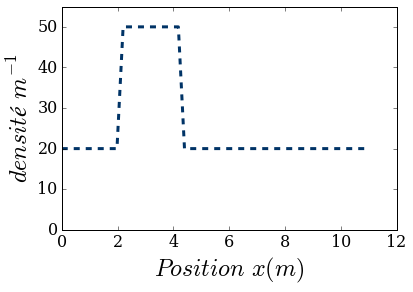

In [58]:
pyplot.ylabel('$densité$'' ''$m^{-1}$', fontsize=24) # nom de l'axe x & taille de la police
pyplot.xlabel('$Position$'' ''$x(m)$', fontsize=24) # nom de l'axe y & taille de la police
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,55);

Quest 1

In [59]:
c = min(v(rho0))
print(round(c*10/36,2))

30.22


Q2.b( avec réécriture des codes)

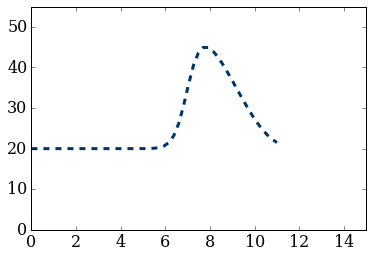

In [60]:
CL     = 20
t_simu = 3
v_max  = 136

vit = numpy.empty(2)
convection1(CL, t_simu, v_max)

In [61]:
print(round(vit[0]*10/36,2))

33.87


Q3( avec réécriture des codes)

In [62]:
print(round(vit[1]*10/36,2))

30.99


---

##### 4. Source:
---


[1] Cours de MATH-F-101 (Calcul Différentiel et Intégral 1) présenté par M. Joel Fine et M. Denis Bonheure à l'ULB.

---

###### The cell below loads the style of the notebook.

In [63]:
from IPython.core.display import HTML
css_file = '../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())